In [35]:
%load_ext autoreload
%autoreload 2
from ASD_Circuits import *

HGNC, ENSID2Entrez, GeneSymbol2Entrez, Entrez2Symbol, allen_mouse_genes = LoadGeneINFO()
ExpMat, ExpZscoreMat, ExpMatNorm, ExpZscoreMatNorm = LoadExpressionMatrices()
gnomad_cons = pd.read_csv("../dat/genes/gnomad.v2.1.1.lof_metrics.by_gene.txt",
                          delimiter="\t", index_col="gene")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [39]:
ExpZ2 = pd.read_csv("dat/ExpMat/Energy.ExpZ2.csv", index_col=0)

In [52]:
# Functions
def CI(simulations, p):
    simulations = sorted(simulations, reverse=False)
    n = len(simulations)
    u_pval = (1+p)/2.
    l_pval = (1-u_pval)
    l_indx = int(np.floor(n*l_pval))
    u_indx = int(np.floor(n*u_pval))
    return(simulations[l_indx],simulations[u_indx])

class STRBias:
    def __init__(self, STR, Bias, Rank):
        self.STR = STR
        self.Bias = Bias
        self.Rank = Rank
        self.Boots = []
    def GetCI(self, p):
        return CI(self.Boots, p)

def LoadBiasData(ASD_Bias, ASD_Boot_Dir, match_dir):
    #ASD_Bias = pd.read_csv(ASD_Bias, index_col="STR")
    ASD_STR_Biases = {}
    for STR, row in ASD_Bias.iterrows():
        ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])

    for i in np.arange(1,1000,1):
        try:
            df = pd.read_csv("{}/bootstrap.{}.csv".format(ASD_Boot_Dir,i), index_col="STR")
        except:
            continue
        for STR, row in df.iterrows():
            ASD_STR_Biases[STR].Boots.append(row["EFFECT"])      
            
    biases_match_rank = {}
    biases_match_STR = {}
    for file in os.listdir(match_dir):
        df = pd.read_csv(match_dir+file, index_col="STR")
        for STR, row in df.iterrows():
            if STR not in biases_match_STR:
                biases_match_STR[STR] = []
            biases_match_STR[STR].append(row["EFFECT"])
            if row["Rank"] not in biases_match_rank:
                biases_match_rank[row["Rank"]] = []
            biases_match_rank[row["Rank"]].append(row["EFFECT"])
    return ASD_STR_Biases, biases_match_rank, biases_match_STR

def LoadBiasData2(Real_Bias, Sim_dir):
    #ASD_Bias = pd.read_csv(ASD_Bias, index_col="STR")
    ASD_STR_Biases = {}
    for STR, row in Real_Bias.iterrows():
        ASD_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])     
            
    biases_match_rank = {}
    biases_match_STR = {}
    for file in os.listdir(Sim_dir):
        if file.startswith("cont.genes"):
            continue
        df = pd.read_csv(Sim_dir+file, index_col="STR")
        for STR, row in df.iterrows():
            if STR not in biases_match_STR:
                biases_match_STR[STR] = []
            biases_match_STR[STR].append(row["EFFECT"])
            if row["Rank"] not in biases_match_rank:
                biases_match_rank[row["Rank"]] = []
            biases_match_rank[row["Rank"]].append(row["EFFECT"])
    return ASD_STR_Biases, biases_match_rank, biases_match_STR

def LoadSiblingBias(Sib_Bias, Sib_Boot_Dir):
    Sib_Bias = pd.read_csv(Sib_Bias, index_col="STR")
    Sib_STR_Biases = {}
    for STR, row in Sib_Bias.iterrows():
        Sib_STR_Biases[STR] = STRBias(STR, row["EFFECT"], row["Rank"])
        #print(Sib_STR_Biases[STR].Bias)

    for i in np.arange(1,1001,1):
        df = pd.read_csv("{}/bootstrap.{}.csv".format(Sib_Boot_Dir,i), index_col="STR")
        for STR, row in df.iterrows():
            Sib_STR_Biases[STR].Boots.append(row["EFFECT"])
    return Sib_STR_Biases

def PlotExpBias(ASD_STR_Biases, Sib_STR_Biases, biases_match_rank, 
                title="Structure Expression Bias of ASD vs Match"):
    fig, ax = plt.subplots(figsize=(6, 8), dpi=720)
    for i, (STR, STR_bias) in enumerate(sorted(ASD_STR_Biases.items(), key=lambda x:x[1].Rank)):
        upper, lower = STR_bias.GetCI(0.95)
        ax.hlines(i+1, lower, upper, color = "blue", lw=0.2)
        x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="blue")
        
    #for i, (STR, STR_bias) in enumerate(sorted(Sib_STR_Biases.items(), key=lambda x:x[1].Rank)):
    #    upper, lower = STR_bias.GetCI(0.95)
    #    ax.hlines(i+1, lower, upper, color = "green", lw=0.2)
    #    x2 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="green")
        
    for i, (Rank, data) in enumerate(sorted(biases_match_rank.items(), key=lambda x:x[0])):
        upper, lower = CI(data, 0.95)
        ax.hlines(i+1 -0.3, lower, upper, color = "red", lw=0.2)
        x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="red")

    plt.gca().invert_yaxis()
    lgnd = ax.legend([x1, x3], 
                     ["Proband Bias", "Matched Bias"], 
                     prop={'size': 8})
    lgnd.legendHandles[0]._sizes = [30]
    lgnd.legendHandles[1]._sizes = [30]
    #lgnd.legendHandles[2]._sizes = [30]

    plt.title(title)
    plt.xlabel("Expression Bias")
    plt.ylabel("Structure Rank")
    plt.grid(True)
    return plt

def avg_indv_bias(sub_bias_mat, topN=10):
    res = []
    for g, row in sub_bias_mat.iterrows():
        row = [x for x in row if x==x]
        sorted_row = sorted(row, reverse=True)
        res.append(np.mean(sorted_row[:topN]))
    return np.mean(res)

# Sibling Mutations and overall burden

In [2]:
ASD_Discov_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Discov_DNVs.txt", delimiter="\t")
ASD_Rep_Muts = pd.read_csv("../dat/genes/SPARK/ASD_Rep_DNVs.txt", delimiter="\t")
ASD_Discov_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Discov_Trios.txt", delimiter="\t")
ASD_Rep_Trios = pd.read_csv("../dat/genes/SPARK/ASD_Rep_Trios.txt", delimiter="\t")

In [3]:
# Get Siblings IDs
ASD_Discov_Sib = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Unaffected"]["IID"].values
ASD_Rep_Sib = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Unaffected"]["IID"].values
Combined_siblings = np.concatenate((ASD_Discov_Sib, ASD_Rep_Sib), axis=None)
N_siblings = Combined_siblings.shape[0]
print(N_siblings)

8267


In [14]:
# Get Siblings IDs
ASD_Discov_Pro = ASD_Discov_Trios[ASD_Discov_Trios["Pheno"]=="Affected"]["IID"].values
ASD_Rep_Pro = ASD_Rep_Trios[ASD_Rep_Trios["Pheno"]=="Affected"]["IID"].values
Combined_probands = np.concatenate((ASD_Discov_Pro, ASD_Rep_Pro), axis=None)
N_probands = Combined_probands.shape[0]
print(N_probands)

23425


In [15]:
AllMuts = pd.concat([ASD_Discov_Muts, ASD_Rep_Muts])
AllMuts = AllMuts.reset_index()
AllSiblingMuts = AllMuts[AllMuts["IID"].isin(Combined_siblings)]
AllProbandMuts = AllMuts[AllMuts["IID"].isin(Combined_probands)]

In [26]:
N_LGD = 0
N_Mis = 0
N_Dmis = 0
N_Syn = 0
for i, row in AllSiblingMuts.iterrows():
    GeneEff = row["GeneEff"].split(";")[0]
    try:
        REVEL = float(row["REVEL"])
    except:
        REVEL = -1
    if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
        N_LGD += 1
    if GeneEff == "missense":
        N_Mis += 1
    if  REVEL>= 0.5:
        N_Dmis += 1
    if GeneEff == "synonymous":
        N_Syn += 1

In [11]:
LGD_Rate = N_LGD / N_siblings
Mis_Rate = N_Mis / N_siblings
DMis_Rate = N_Dmis / N_siblings
Syn_Rate = N_Syn / N_siblings
print(LGD_Rate,Mis_Rate,DMis_Rate,Syn_Rate)

0.07790008467400508 0.5632030966493287 0.1097133180113705 0.22087819039554857


In [12]:
BGMR = pd.read_csv("/Users/jiayao/Work/Resources/MutationRate_20170710_rate.txt", delimiter="\t")

/Users/jiayao/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3267: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [13]:
LGD_Exp = 2 * BGMR["p_LGD"].sum() 
Mis_Exp = 2 * BGMR["p_misense"].sum() 
DMis_Exp = 2 * BGMR["prevel_0.5"].sum() 
Syn_Exp = 2 * BGMR["p_synonymous"].sum() 
print(LGD_Exp, Mis_Exp, DMis_Exp, Syn_Exp)

0.09336622119092114 0.683226204498098 0.13970980260843366 0.3089768846645528


In [21]:
fix_rate = 0.3089768846645528 / 0.22087819039554857
fid_N_siblings = N_siblings / fix_rate
print(fid_N_siblings)

5909.827209185681


In [32]:
fix_N_siblings = 6500

In [33]:
LGD_Rate = N_LGD / fix_N_siblings
Mis_Rate = N_Mis / fix_N_siblings
DMis_Rate = N_Dmis / fix_N_siblings
Syn_Rate = N_Syn / fix_N_siblings
print(LGD_Rate,Mis_Rate,DMis_Rate,Syn_Rate)

0.09907692307692308 0.7163076923076923 0.13953846153846153 0.28092307692307694


In [16]:
N_LGD_proband = 0
N_Mis_proband = 0
N_Dmis_proband = 0
N_Syn_proband = 0
for i, row in AllProbandMuts.iterrows():
    GeneEff = row["GeneEff"].split(";")[0]
    try:
        REVEL = float(row["REVEL"])
    except:
        REVEL = -1
    if GeneEff in ["frameshift", "splice_acceptor", "splice_donor", "start_lost", "stop_gained", "stop_lost"]:
        N_LGD_proband += 1
    if GeneEff == "missense":
        N_Mis_proband += 1
    if  REVEL>= 0.5:
        N_Dmis_proband += 1
    if GeneEff == "synonymous":
        N_Syn_proband += 1

In [17]:
LGD_Rate_proband = N_LGD_proband / N_probands
Mis_Rate_proband = N_Mis_proband / N_probands
DMis_Rate_proband = N_Dmis_proband / N_probands
Syn_Rate_proband = N_Syn_proband / N_probands
print(LGD_Rate_proband,Mis_Rate_proband,DMis_Rate_proband,Syn_Rate_proband)

0.12738527214514409 0.6039701173959445 0.14992529348986125 0.23372465314834578


In [22]:
fix_N_probands = N_probands / fix_rate
LGD_Rate_proband = N_LGD_proband / fix_N_probands
Mis_Rate_proband = N_Mis_proband / fix_N_probands
DMis_Rate_proband = N_Dmis_proband / fix_N_probands
Syn_Rate_proband = N_Syn_proband / fix_N_probands
print(LGD_Rate_proband,Mis_Rate_proband,DMis_Rate_proband,Syn_Rate_proband)

0.1781937115161465 0.844867503528968 0.20972396610077293 0.32694724214172316


# Sibling Bias

#### Prob of sampling genes accroding to mutability

In [36]:
# Calculate Prob
allen_mouse_genes = loadgenelist("../dat/allen-mouse-exp/allen-mouse-gene_entrez.txt")
BGMR = pd.read_csv("/Users/jiayao/Work/Resources/MutationRate_20170710_rate.txt", delimiter="\t")
BGMR["Entrez"] = [int(GeneSymbol2Entrez.get(x, -1)) for x in BGMR["GeneName"].values]
BGMR = BGMR[BGMR["Entrez"].isin(allen_mouse_genes)]
BGMR.index=BGMR["Entrez"].values

BGMR["Mutability"] = BGMR["p_LGD"] + BGMR["prevel_0.5"]
BGMR["Mutability2"] = BGMR["p_synonymous"]

Total_Mut = BGMR["Mutability"].sum()
Total_Mut2 = BGMR["Mutability2"].sum()

LGD_Dmis_Mut = BGMR["Mutability"].values / Total_Mut
LGD_Dmis_Mut[-1] = 1 - np.sum(LGD_Dmis_Mut[:-1])
Syn_Mut = BGMR["Mutability2"].values / Total_Mut2
Syn_Mut[-1] = 1 - np.sum(Syn_Mut[:-1])

df = pd.DataFrame(data={"Genes": BGMR.index.values, "Prob":LGD_Dmis_Mut})
df.to_csv("Jan20_Gene_n_Prob.csv", index=False)
df = pd.DataFrame(data={"Genes": BGMR.index.values, "Prob":Syn_Mut})
df.to_csv("Jan20_Gene_n_Prob.syn.csv", index=False)

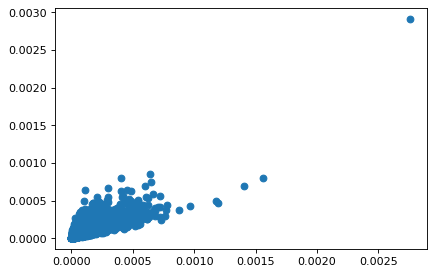

In [37]:
plt.scatter(LGD_Dmis_Mut, Syn_Mut)

### sibling bias calculation (LGD/Dmis)

In [40]:
SiblingDF = pd.read_csv("dat/ASD_Siblings.csv")
SiblingDF.head(2)

,HGNC,Entrez,N_LGD,N_Mis,N_Dmis,N_Syn
0,ZNF679,168417,0,2,0,0
1,ARHGAP12,94134,0,1,1,0


In [42]:
weight_dict = {}
for index, row in SiblingDF.iterrows():
    weight = row["N_LGD"] * 0.375 + row["N_Dmis"] * 0.231
    if weight >0:
        weight_dict[row["Entrez"]] = weight
        
writer = csv.writer(open("dat/sibling_weights_LGD_Dmis.csv", 'wt'))
for k,v in sorted(weight_dict.items(), key=lambda x:x[1], reverse=True):
    if k in BGMR.index.values and v > 0:
        writer.writerow([k,v])
WeightDF = pd.read_csv("dat/sibling_weights_LGD_Dmis.csv", header=None)
weight_dict = dict(zip(WeightDF[0].values, WeightDF[1].values))


Sib_LGD_Dmis_Bias_DF = AvgSTRZ_Weighted(ExpZ2, weight_dict, csv_fil="dat/sib.bias.csv")

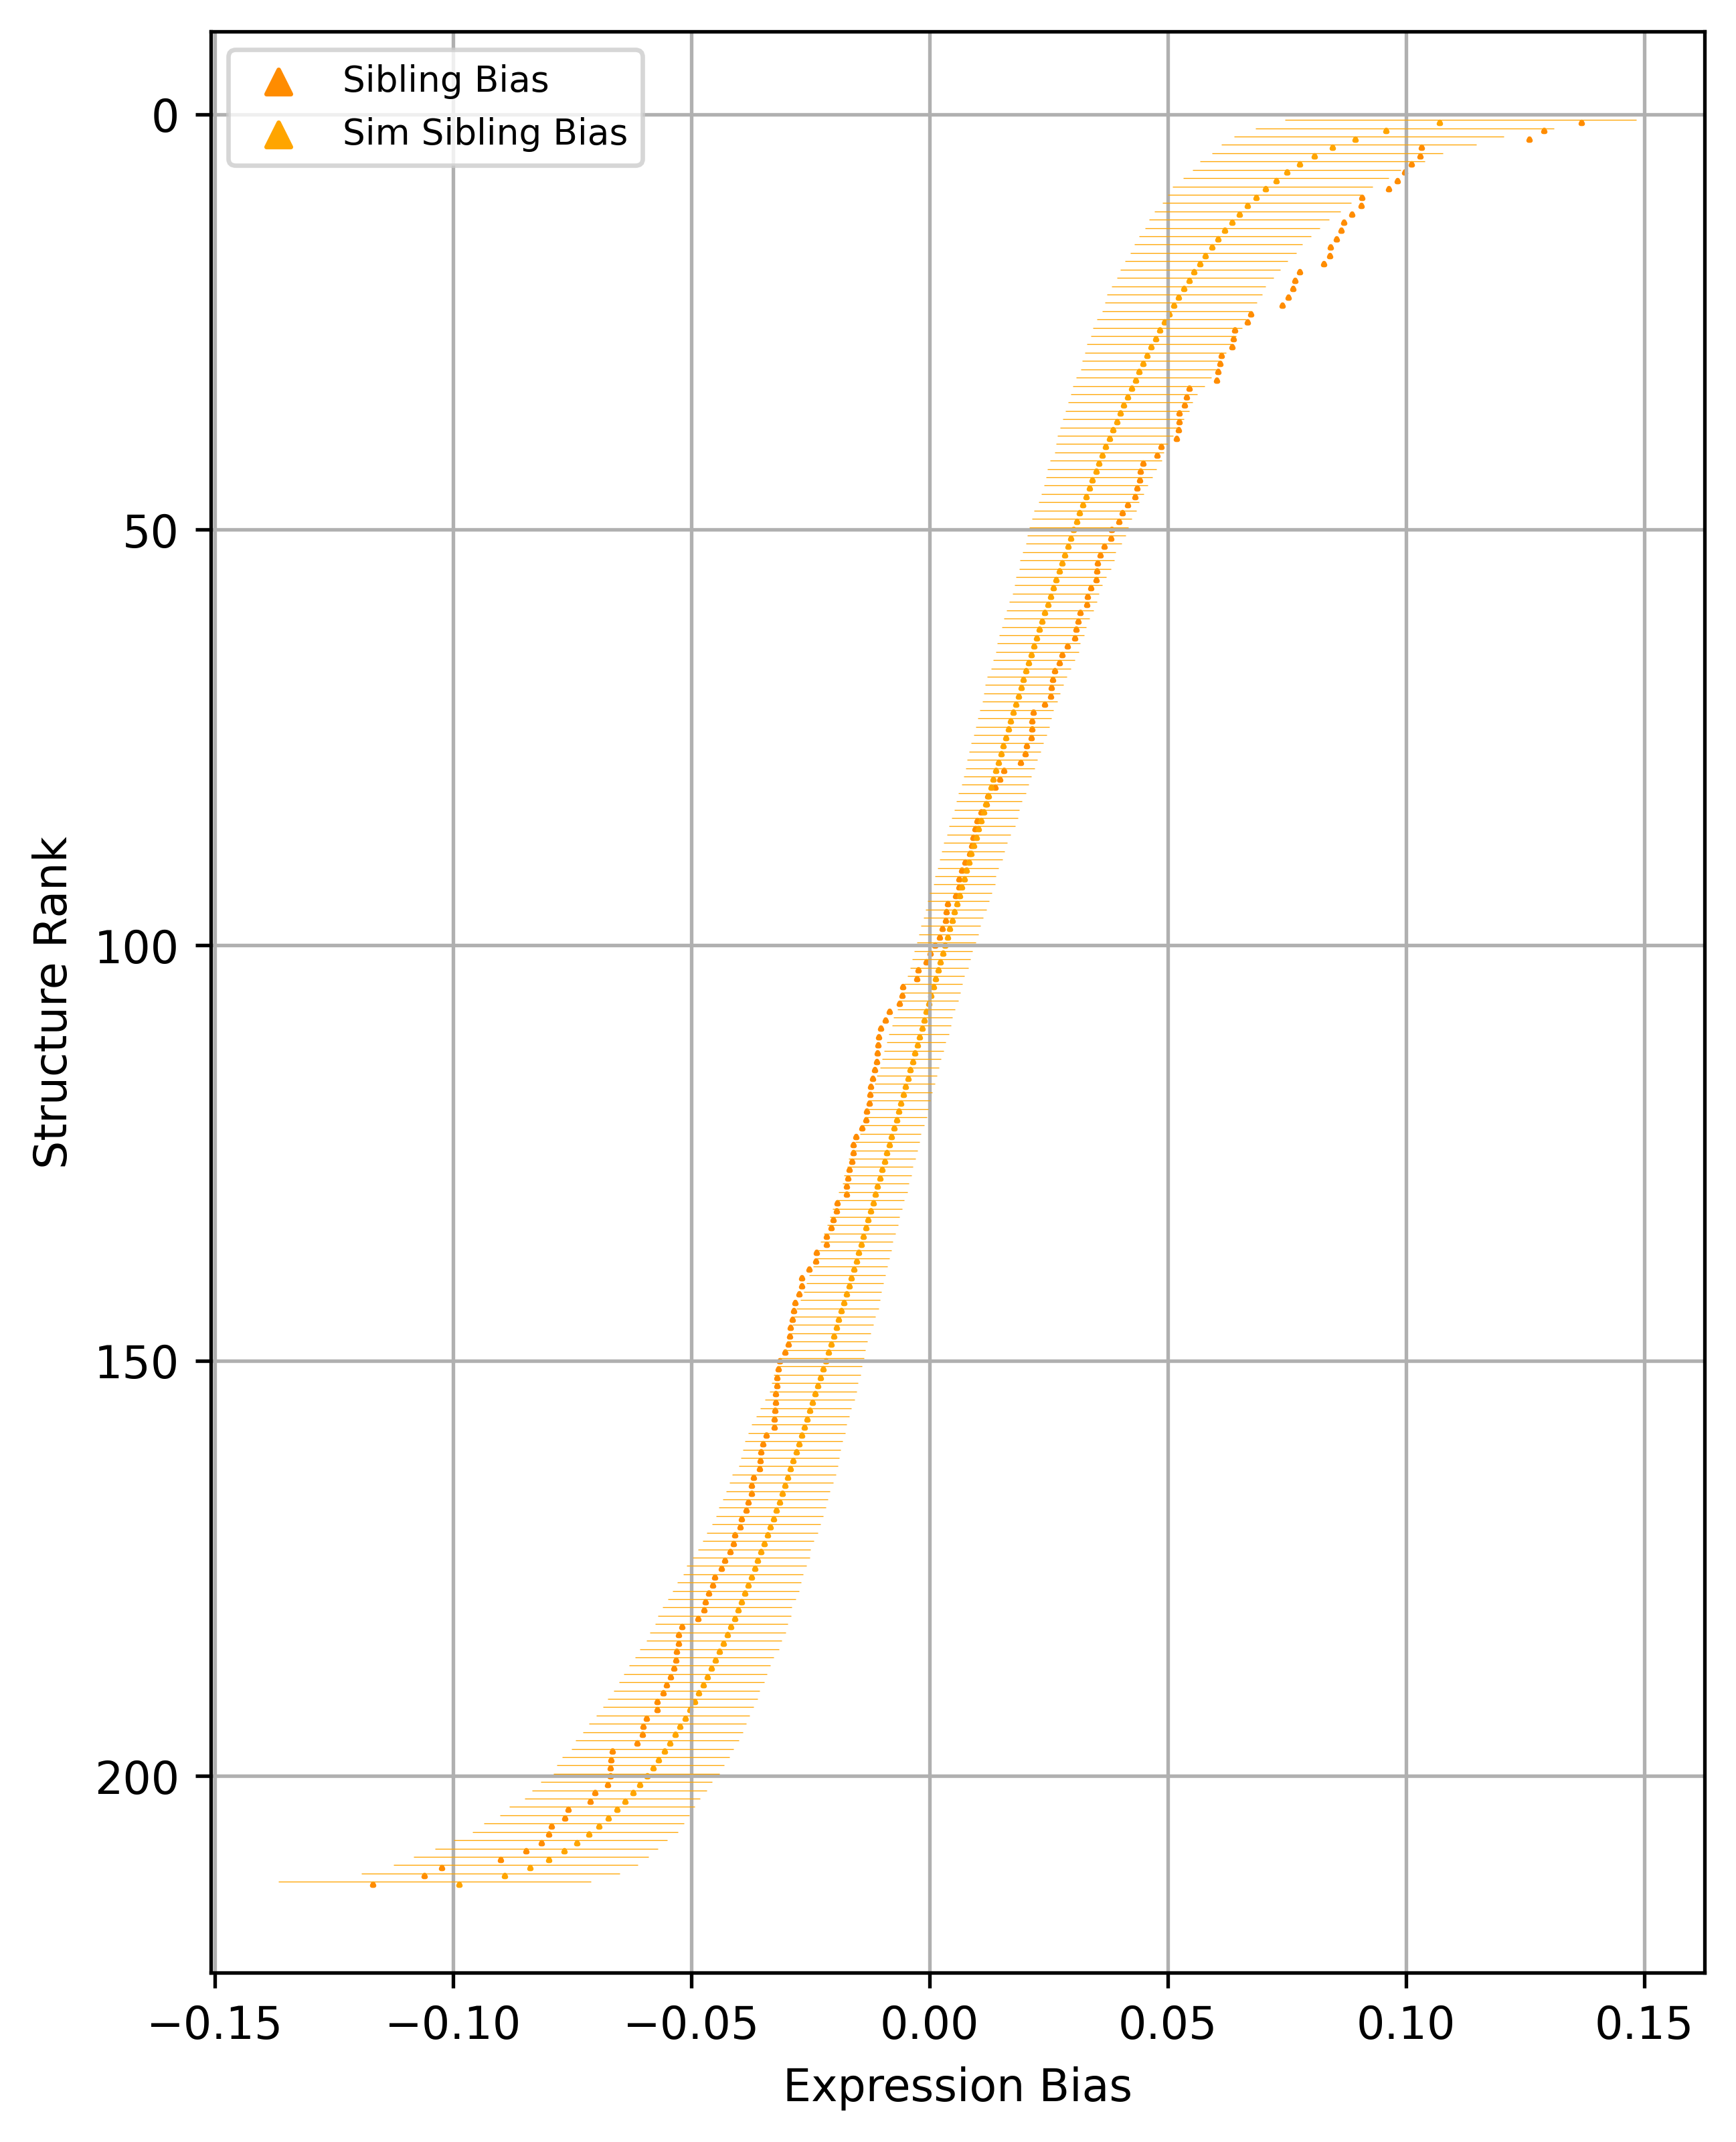

In [45]:
Sib_Sim_Dir = "dat/SimulateControlBiasDefault/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_LGD_Dmis_Bias_DF, Sib_Sim_Dir)
fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x2 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2], 
                 ["Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]

plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
#return plt

No handles with labels found to put in legend.


<AxesSubplot:>

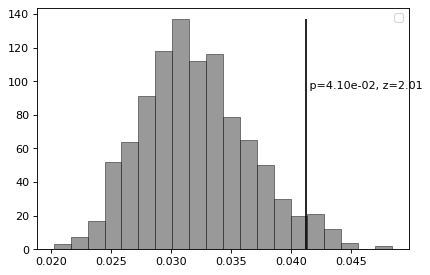

In [48]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    if file.startswith("cont.bias"):
        df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
        biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
bias_sib = np.mean([abs(x) for x in Sib_LGD_Dmis_Bias_DF["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

In [53]:
sim_avg_bias = []
for file in os.listdir(Sib_Sim_Dir):
    if file.startswith("cont.genes"):
        sib_genes = [int(x) for x in LoadList(Sib_Sim_Dir + file) if int(x) in ExpZ2.index.values]
        indv_bias = ExpZ2.loc[sib_genes, :]
        sim_avg_bias.append(avg_indv_bias(indv_bias))

In [54]:
sib_real_genes = list(weight_dict.keys())
sib_real_expbias = ExpZ2.loc[sib_real_genes, :]
mean_sib_bias = avg_indv_bias(sib_real_expbias)
print(mean_sib_bias)

2.4831515873034804


<AxesSubplot:title={'center':'avg individual top10 bias'}, xlabel='real sib'>

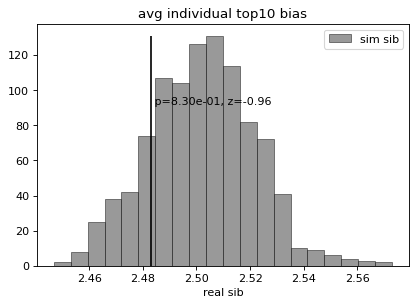

In [55]:
fig, ax = plt.subplots()
PlotPermutationP(sim_avg_bias, mean_sib_bias, ax, xlabel="real sib", dist_label="sim sib", title=
                "avg individual top10 bias")

### sibling bias calculation (Syn)

In [56]:
SynSibDF = SiblingDF[SiblingDF["N_Syn"]>=1]
Syn_weights = dict(zip(SynSibDF["Entrez"].values, SynSibDF["N_Syn"].values))
print(len(Syn_weights))
Sib_syn_bias = AvgSTRZ_Weighted(ExpZ2, Syn_weights, csv_fil="dat/sib.syn.bias.csv")
Sib_syn_bias = Sib_syn_bias.set_index("STR")

writer = csv.writer(open("dat/sibling_weights_syn.csv", 'wt'))
for k,v in sorted(Syn_weights.items(), key=lambda x:x[1], reverse=True):
    if k in BGMR.index.values and v > 0:
        writer.writerow([k,v])
WeightDF = pd.read_csv("dat/sibling_weights_syn.csv", header=None)
Syn_weights2 = dict(zip(WeightDF[0].values, WeightDF[1].values))

Sib_syn_bias = AvgSTRZ_Weighted(ExpZ2, Syn_weights2, csv_fil="dat/sib.syn.2.bias.csv")
Sib_syn_bias = Sib_syn_bias.set_index("STR")
Sib_syn_bias.head(50)["EFFECT"].mean()

1597


0.05768111622553025

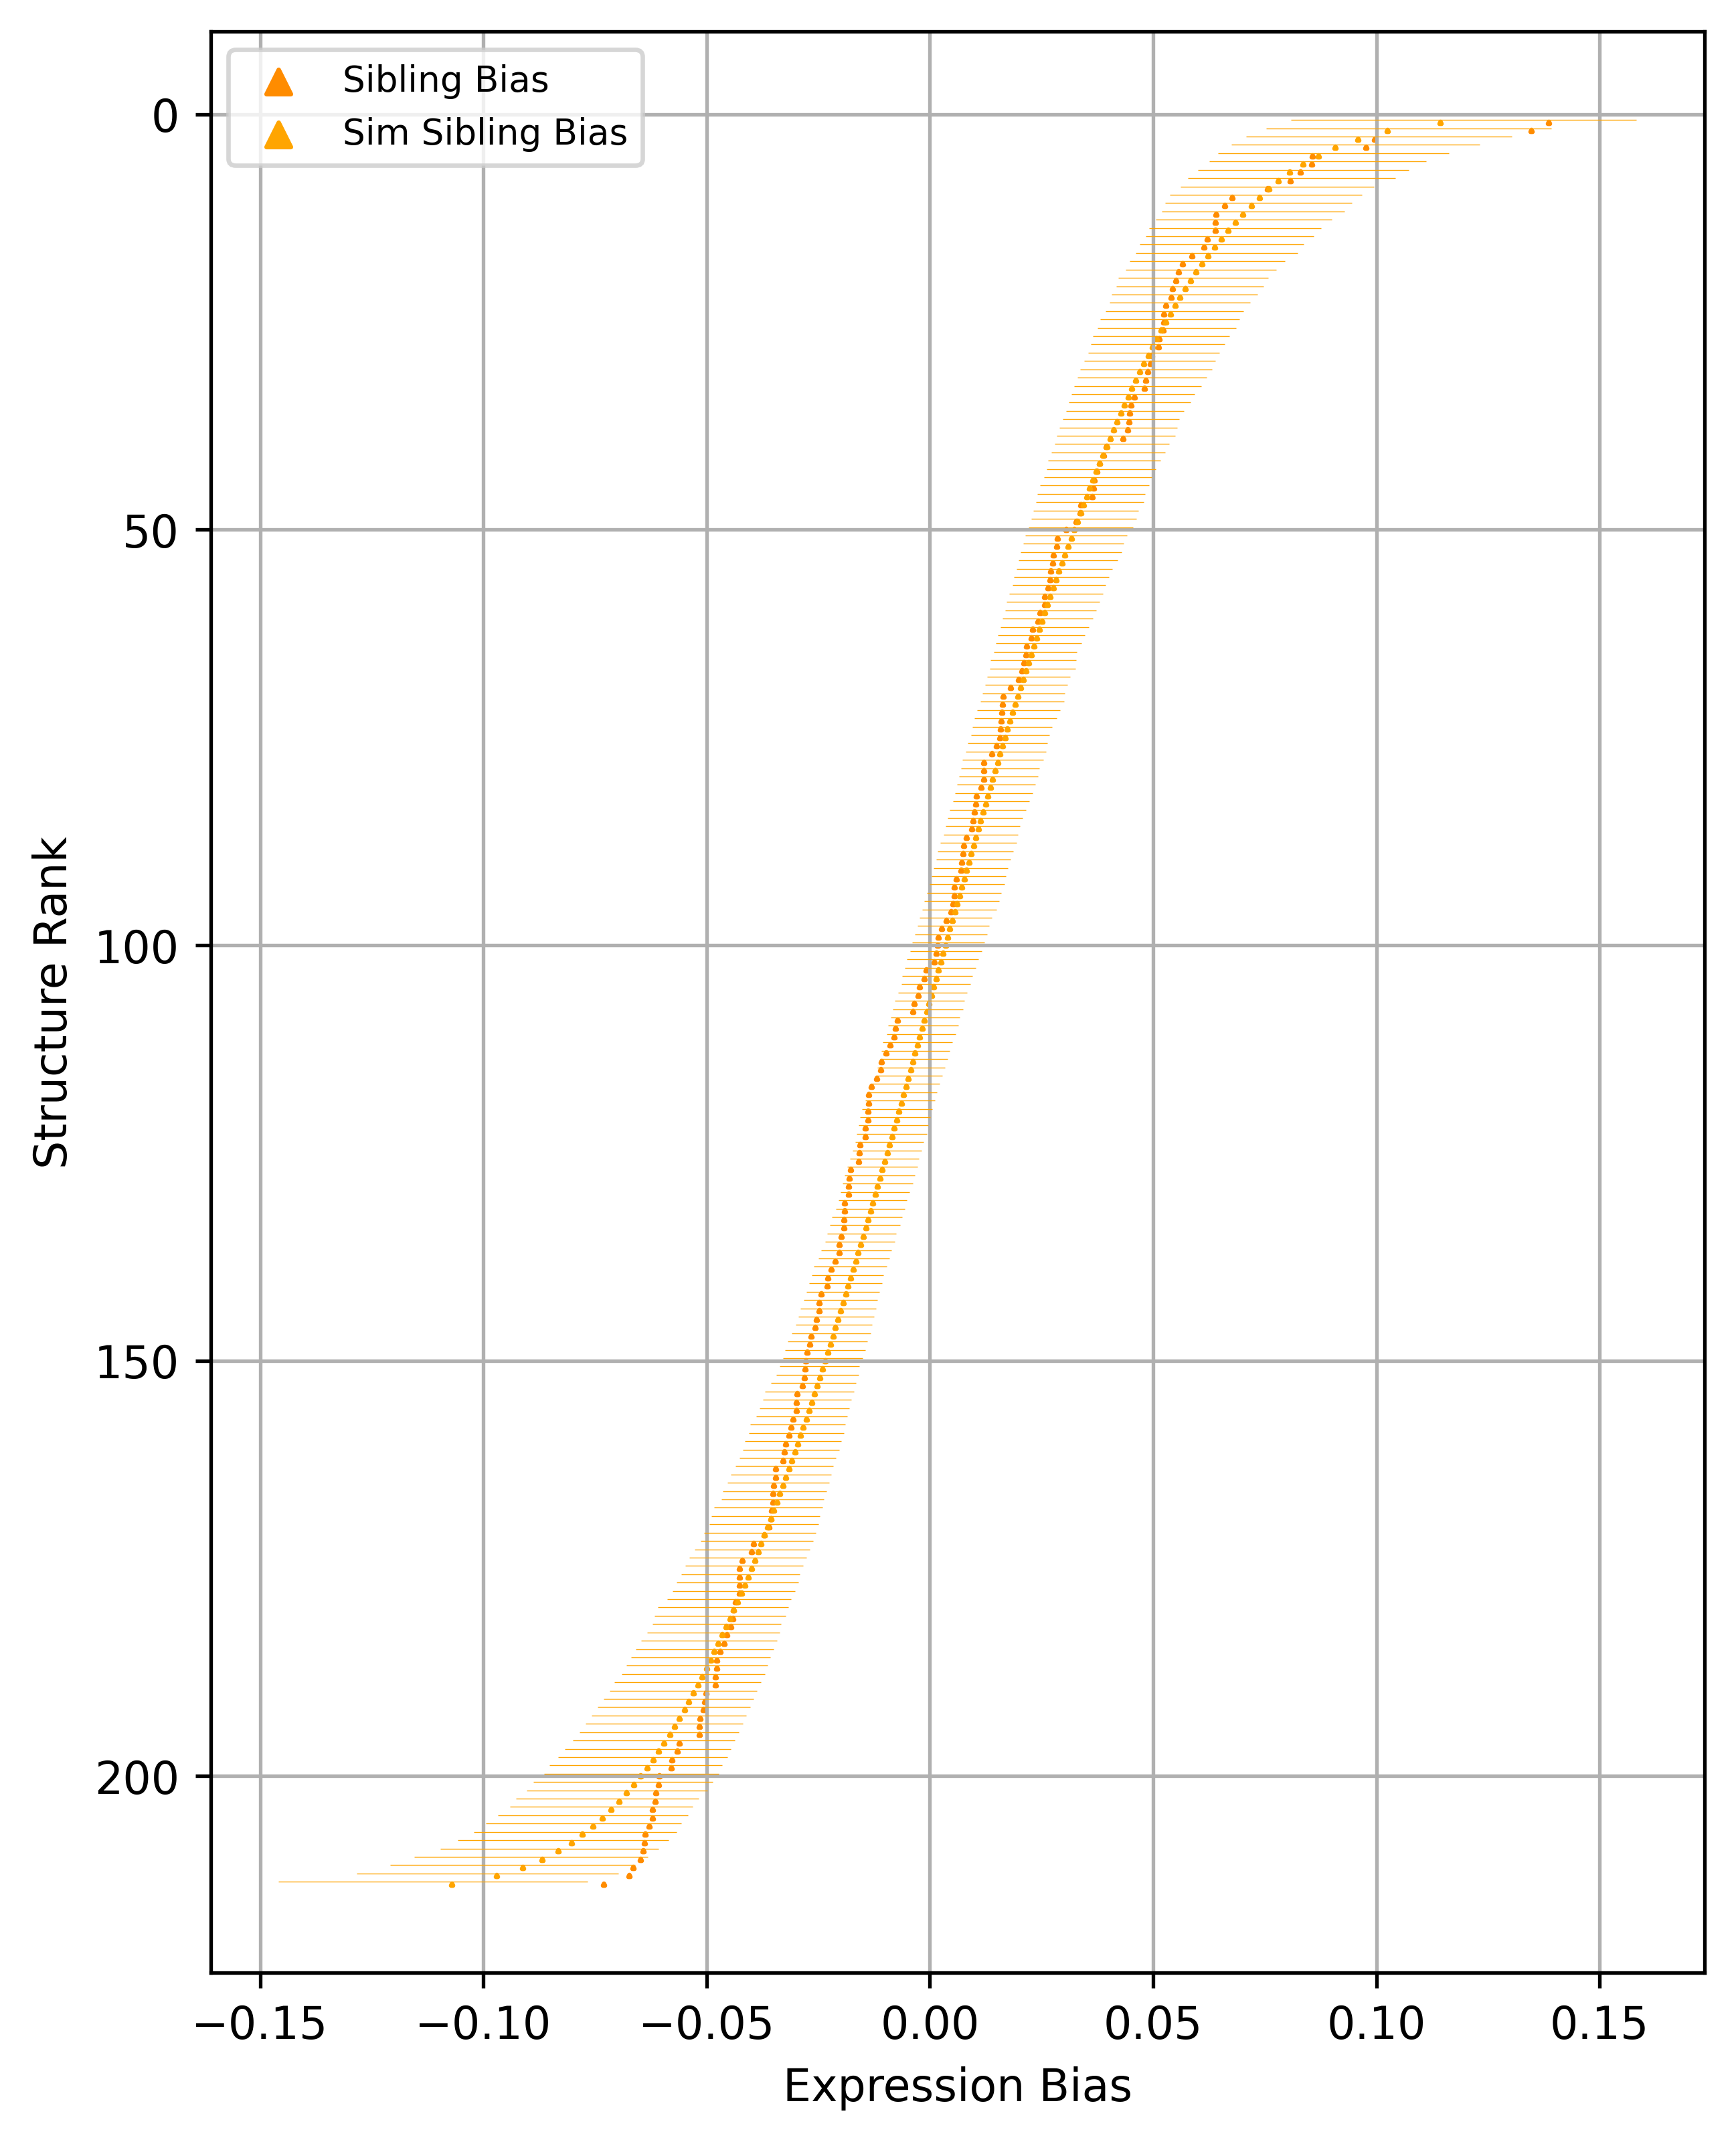

In [57]:
Sib_Sim_Dir = "dat/Control_GeneSet_Bias/Rand_Gene_Syn_Sib/"
Sib_Z2_Bias, Sib_Sim_Bias_Rank, Sib_Sim_Bias_STR = LoadBiasData2(Sib_syn_bias, Sib_Sim_Dir)

fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Sib_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkorange")
for i, (Rank, data) in enumerate(sorted(Sib_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "orange", lw=0.2)
    x3 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="orange")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2], 
                 ["Sibling Bias", "Sim Sibling Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]


plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)

No handles with labels found to put in legend.


<AxesSubplot:>

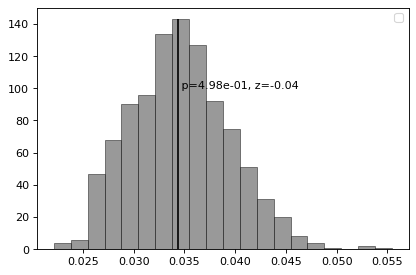

In [62]:
# Sibling bootstraped biases
biases_sib_boot = []
for file in os.listdir(Sib_Sim_Dir):
    if file.startswith("cont.bias"):
        df = pd.read_csv(Sib_Sim_Dir+file, index_col="STR")
        biases_sib_boot.append(np.mean([abs(x) for x in df["EFFECT"].values]))
bias_sib = np.mean([abs(x) for x in Sib_syn_bias["EFFECT"].values])

fig, ax = plt.subplots()
PlotPermutationP(biases_sib_boot, bias_sib, ax)

In [58]:
sim_avg_bias = []
for file in os.listdir(Sib_Sim_Dir):
    if file.startswith("cont.genes"):
        sib_genes = [int(x) for x in LoadList(Sib_Sim_Dir + file) if int(x) in ExpZ2.index.values]
        indv_bias = ExpZ2.loc[sib_genes, :]
        sim_avg_bias.append(avg_indv_bias(indv_bias))

In [65]:
sib_real_genes = list(Syn_weights2.keys())
sib_real_genes = [x for x in sib_real_genes if x in ExpZ2.index.values]
sib_real_expbias = ExpZ2.loc[sib_real_genes, :]
mean_sib_bias = avg_indv_bias(sib_real_expbias)
print(mean_sib_bias)

2.5094837854734724


<AxesSubplot:title={'center':'avg individual top10 bias'}, xlabel='real sib'>

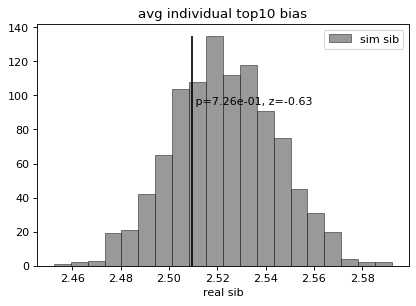

In [66]:
fig, ax = plt.subplots()
PlotPermutationP(sim_avg_bias, mean_sib_bias, ax, xlabel="real sib", dist_label="sim sib", title=
                "avg individual top10 bias")

## Neg Bias

In [68]:
Neg_bias = pd.read_csv("dat/bias2/ASD.Neg.Z2.csv", index_col="STR")
Neg_bias.head(50)["EFFECT"].mean()

0.5095622091512577

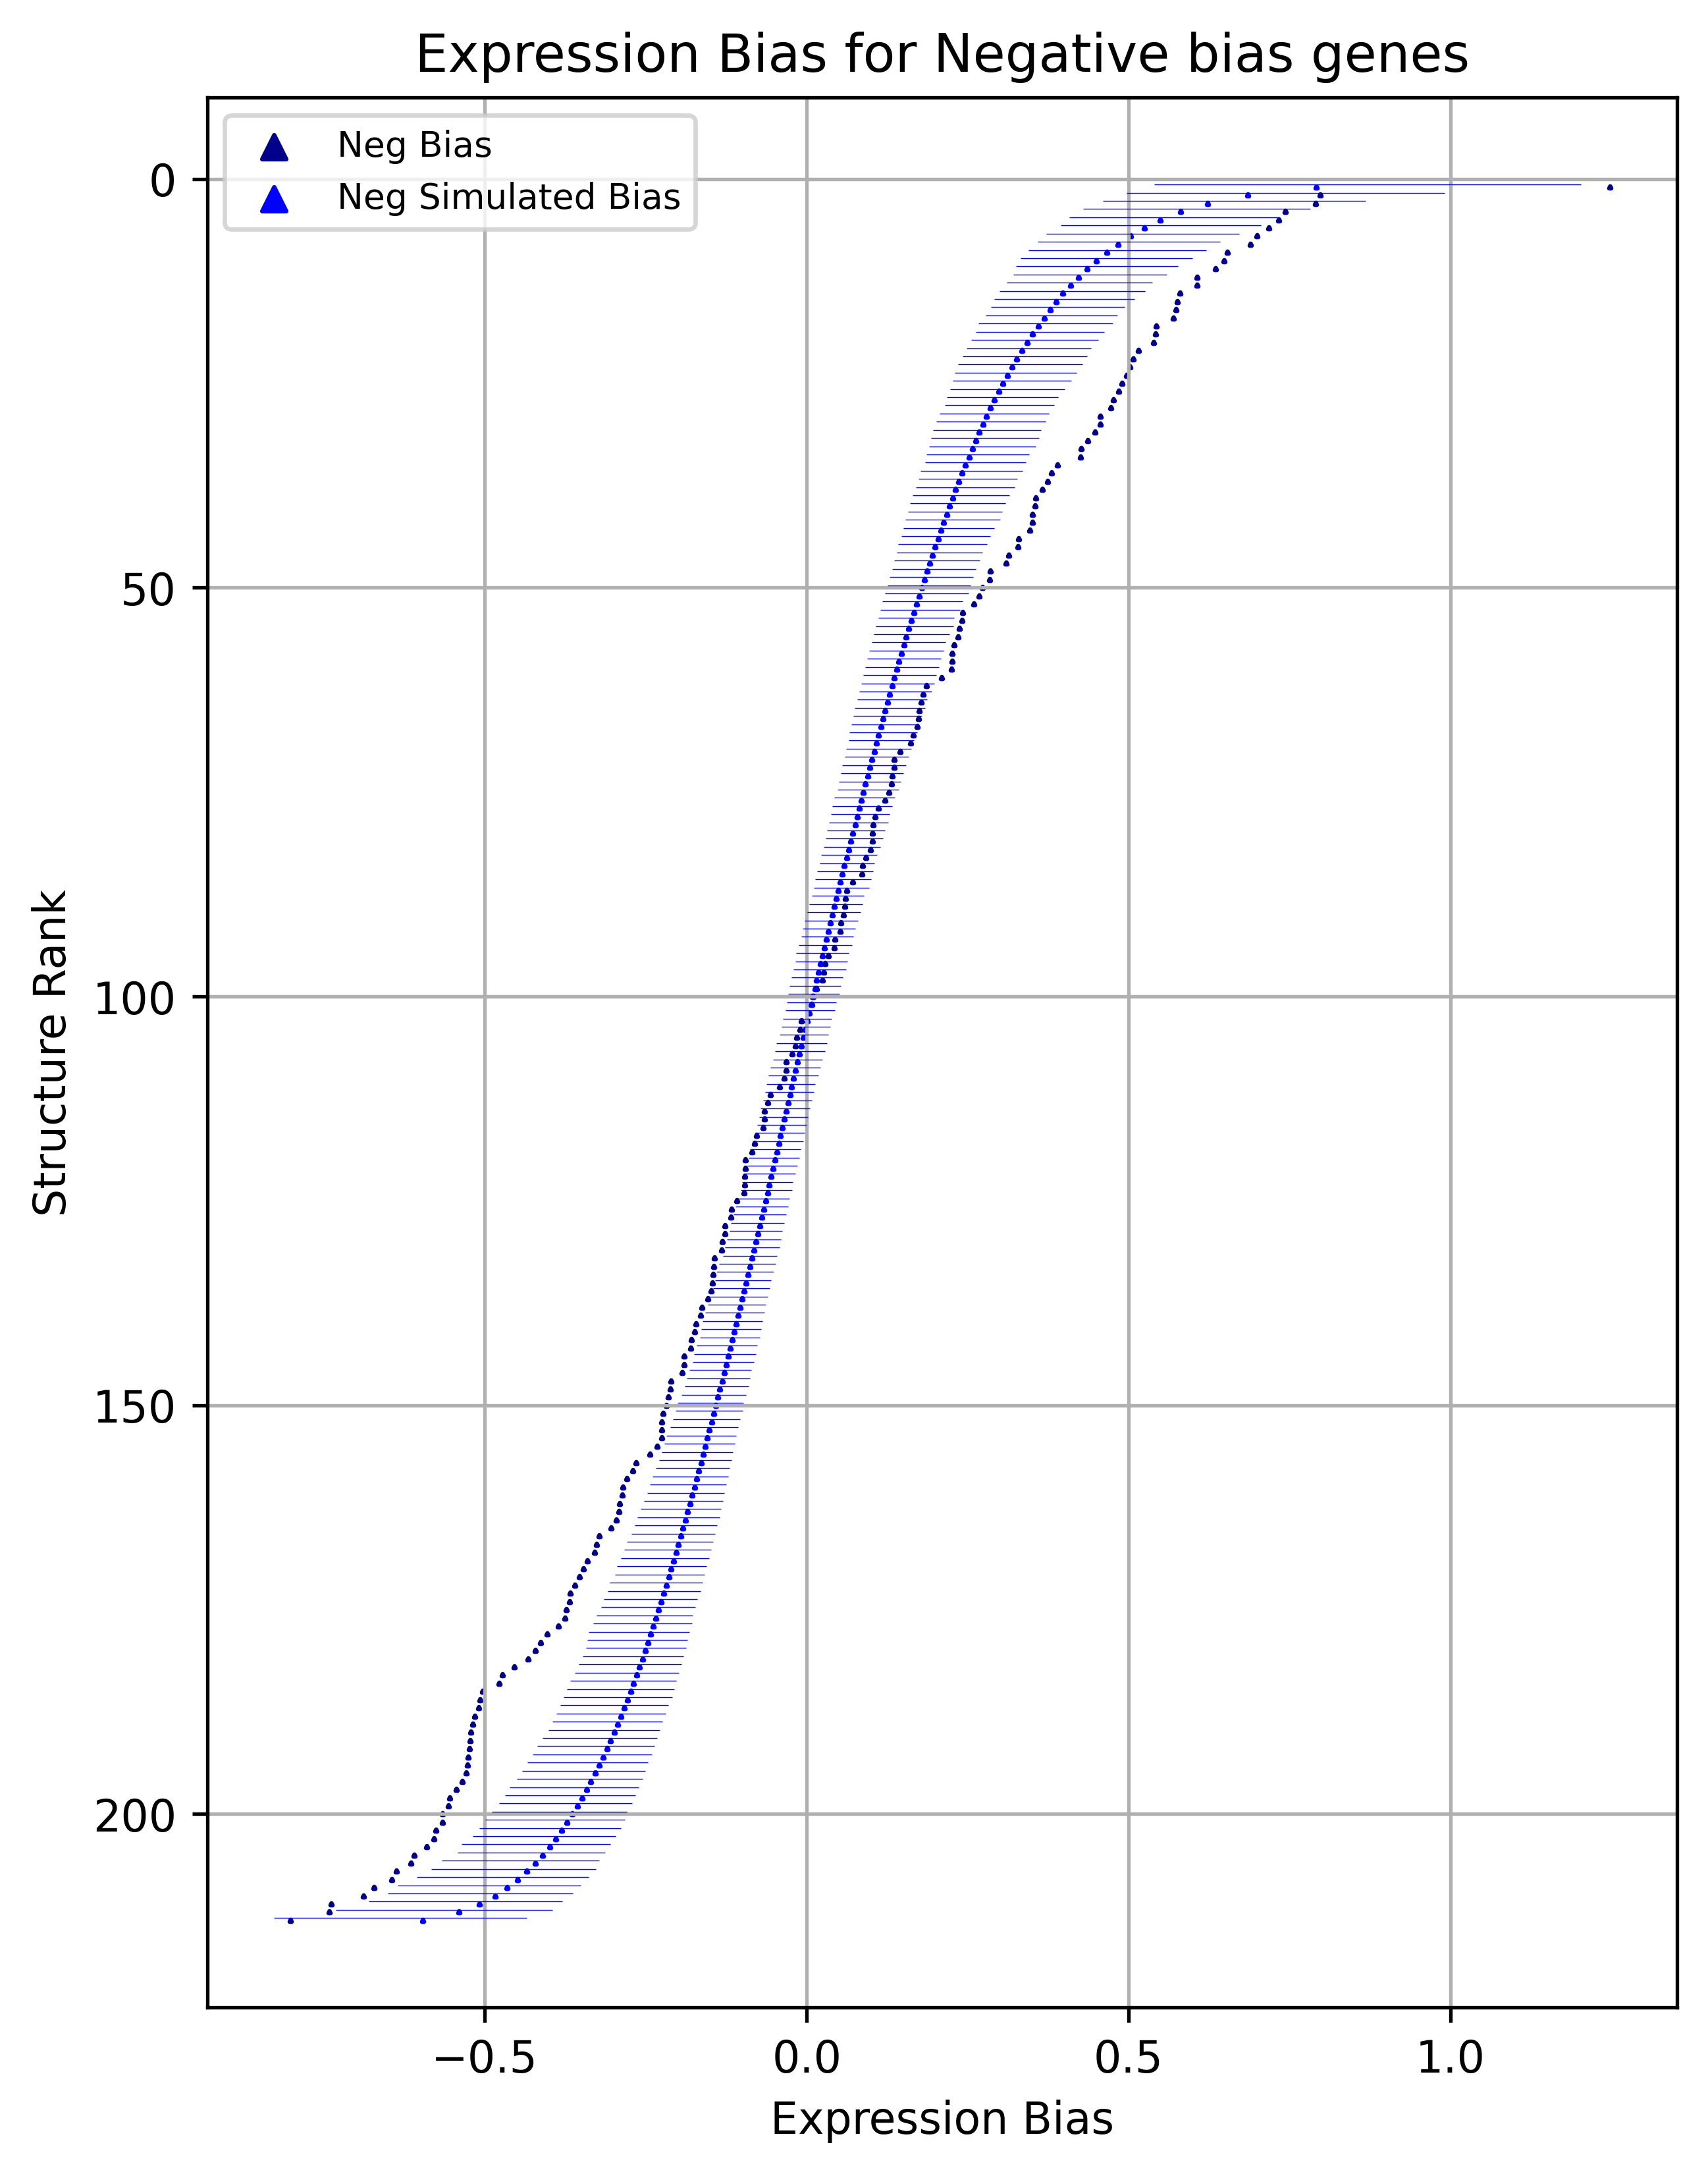

In [74]:
Neg_Sim_Dir = "dat/Control_GeneSet_Bias/Proband_Neg_Rand_Gene/"
Neg_Z2_Bias, Neg_Sim_Bias_Rank, Neg_Sim_Bias_STR = LoadBiasData2(Neg_bias, Neg_Sim_Dir)

fig, ax = plt.subplots(figsize=(6, 8), dpi=480)

for i, (STR, STR_bias) in enumerate(sorted(Neg_Z2_Bias.items(), key=lambda x:x[1].Rank)):
    x1 = ax.scatter(STR_bias.Bias, i+1, marker="^", s=0.2, color="darkblue")
for i, (Rank, data) in enumerate(sorted(Neg_Sim_Bias_Rank.items(), key=lambda x:x[0])):
    upper, lower = CI(data, 0.95)
    ax.hlines(i+1 -0.3, lower, upper, color = "blue", lw=0.2)
    x2 = ax.scatter(np.mean(data), i+1, marker="^", s=0.2, color="blue")
    
plt.gca().invert_yaxis()
lgnd = ax.legend([x1, x2], 
                 ["Neg Bias", "Neg Simulated Bias"], 
                 prop={'size': 8})

lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]


plt.xlabel("Expression Bias")
plt.ylabel("Structure Rank")
plt.grid(True)
plt.title("Expression Bias for Negative bias genes")
plt.savefig("figs/Expression_Bias_for_Negative_bias_genes.pdf")